In [1]:
import numpy as np
import pandas as pd

from datetime import datetime

from sklearn.metrics import mean_squared_error

from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import acquire as ac
import prepare as pr

import warnings
warnings.filterwarnings("ignore")

In [2]:
# cameron's code for using i as a label for the iterable output
# for i in range(3):
#     locals()['x' + str(i)] = i
# x2

In [3]:
df = ac.get_sales()
df

,sale_amount,sale_date,sale_id,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_id,store_state,store_zipcode
0,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
2,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
3,13.0,"Fri, 04 Jan 2013 00:00:00 GMT",4,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
4,10.0,"Sat, 05 Jan 2013 00:00:00 GMT",5,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912995,63.0,"Wed, 27 Dec 2017 00:00:00 GMT",912996,Choice,50,Choice Organic Teas Black Tea Classic Black - ...,5.20,47445919221,47445919221,8503 NW Military Hwy,San Antonio,10,TX,78231
912996,59.0,"Thu, 28 Dec 2017 00:00:00 GMT",912997,Choice,50,Choice Organic Teas Black Tea Classic Black - ...,5.20,47445919221,47445919221,8503 NW Military Hwy,San Antonio,10,TX,78231
912997,74.0,"Fri, 29 Dec 2017 00:00:00 GMT",912998,Choice,50,Choice Organic Teas Black Tea Classic Black - ...,5.20,47445919221,47445919221,8503 NW Military Hwy,San Antonio,10,TX,78231
912998,62.0,"Sat, 30 Dec 2017 00:00:00 GMT",912999,Choice,50,Choice Organic Teas Black Tea Classic Black - ...,5.20,47445919221,47445919221,8503 NW Military Hwy,San Antonio,10,TX,78231


## 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.


---
### Prepare

In [4]:
df.rename(columns={"sale_amount": "quantity"}, inplace=True)

In [5]:
df = df.assign(ds = pd.to_datetime(df.sale_date)).sort_values("ds")\
    .assign(sale_amount = df.quantity * df.item_price)\
    .groupby(["ds"])[["quantity", "sale_amount"]].sum()\
    .reset_index().set_index("ds")
df

,quantity,sale_amount
ds,,
2013-01-01 00:00:00+00:00,13696.0,73844.01
2013-01-02 00:00:00+00:00,13678.0,73570.58
2013-01-03 00:00:00+00:00,14488.0,78169.48
2013-01-04 00:00:00+00:00,15677.0,84467.73
2013-01-05 00:00:00+00:00,16237.0,87621.85
...,...,...
2017-12-27 00:00:00+00:00,20378.0,109151.15
2017-12-28 00:00:00+00:00,21885.0,117377.49
2017-12-29 00:00:00+00:00,23535.0,126541.84


---

**Resample by month + Aggregate using sum**

In [6]:
df = df.resample("W").sum()

**Split**

In [7]:
train = df[:"2016-12-25"]
test = df["2017-01-01":]
train.tail()

,quantity,sale_amount
ds,,
2016-11-27 00:00:00+00:00,208743.0,1122205.56
2016-12-04 00:00:00+00:00,171559.0,923191.49
2016-12-11 00:00:00+00:00,149165.0,799959.63
2016-12-18 00:00:00+00:00,149388.0,802545.25
2016-12-25 00:00:00+00:00,149381.0,802308.50


In [8]:
print(test.shape)
test.head()

(53, 2)


,quantity,sale_amount
ds,,
2017-01-01 00:00:00+00:00,146640.0,788100.24
2017-01-08 00:00:00+00:00,140112.0,755550.37
2017-01-15 00:00:00+00:00,139901.0,752373.86
2017-01-22 00:00:00+00:00,139914.0,750565.94
2017-01-29 00:00:00+00:00,139345.0,748669.80


**Validate Split**

In [9]:
print((train.shape[0] + test.shape[0]) == df.shape[0])
print(train.head(1) == df.head(1))
print(test.tail(1) == df.tail(1))

True
                           quantity  sale_amount
ds                                              
2013-01-06 00:00:00+00:00      True         True
                           quantity  sale_amount
ds                                              
2017-12-31 00:00:00+00:00      True         True


## 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you.

In [10]:
def make_predictions():
    """
    This function creates a forecast depending the specified method of calculating
    the quantity and sale_amount variables as global variables outside the function
    """
    
    # create yhat DataFrame
    yhat = pd.DataFrame({
        "quantity": quantity, 
        "sale_amount": sale_amount,
    }, index=test.index)
    
    return yhat

In [11]:
def evaluate(target_var):
    """
    This function evaluates the forecasting model using the root mean squared error of the target variable
    """
    
    # calcuated RMSE
    rmse = round(sqrt(mean_squared_error(test[target_var], yhat[target_var])))
    
    return rmse

In [12]:
def plot_and_eval(target_var):
    """
    This function plots the train, test, and forecast for the target variable and evaluates the model
    """
    
    # set figure size
    plt.figure(figsize=(16, 4))
    
    # plot train target variable
    plt.plot(train[target_var], label="Train", linewidth=1)
    
    # plot test target variable
    plt.plot(test[target_var], label="Test", linewidth=1)
    
    # plot forecast target variable
    plt.plot(yhat[target_var], label="yhat", linewidth=1)
    
    # title of plot
    plt.title(target_var)
    
    # calling evaluate function to calculate the RMSE of the model
    rmse = evaluate(target_var)
    
    # printing the RMSE for the target_variable
    print(target_var, f"-- RMSE: {rmse:.0f}")
    
    # plot legend
    plt.legend()
    
    # show the plot
    plt.show()

In [13]:
def append_evaluation(model_type, target_var):
    """
    This function appends the evaluation of a specific model to a DataFrame for future reference
    This function operates under the assumption of the existance of an evaluation DataFrame
    """
    
    # calling evaluate function to calculate the RMSE of the model
    rmse = evaluate(target_var)
    
    # creating dictionary with model specification, target_variable, and evaluation metric
    d = {"model_type": [model_type], "target_var": [target_var], "rmse": rmse}
    
    # creating a DataFrame from the dictionary above
    d = pd.DataFrame(d)
    
    # appending values to the evaluation DataFrame and returning said DataFrame
    return evaluation.append(d, ignore_index=True)

---
**Simple Average**

In [14]:
train.head()

,quantity,sale_amount
ds,,
2013-01-06 00:00:00+00:00,91067.0,490767.50
2013-01-13 00:00:00+00:00,103902.0,559934.21
2013-01-20 00:00:00+00:00,102950.0,552813.52
2013-01-27 00:00:00+00:00,103298.0,554908.84
2013-02-03 00:00:00+00:00,109027.0,586547.55


**Predict**

In [15]:
quantity = round(train["quantity"].mean(), 2)
sale_amount = round(train["sale_amount"].mean(), 2)

yhat = make_predictions()

print(yhat.shape)
yhat.head()

(53, 2)


,quantity,sale_amount
ds,,
2017-01-01 00:00:00+00:00,177153.08,952417.26
2017-01-08 00:00:00+00:00,177153.08,952417.26
2017-01-15 00:00:00+00:00,177153.08,952417.26
2017-01-22 00:00:00+00:00,177153.08,952417.26
2017-01-29 00:00:00+00:00,177153.08,952417.26


**Evaluate**

In [16]:
for col in train.columns:
    print(f"{col} RMSE = {evaluate(col)}")

quantity RMSE = 46568
sale_amount RMSE = 250161


**Plot + Evaluate**

quantity -- RMSE: 46568


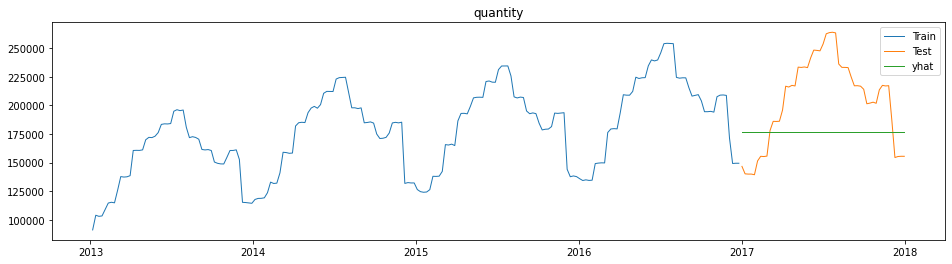

sale_amount -- RMSE: 250161


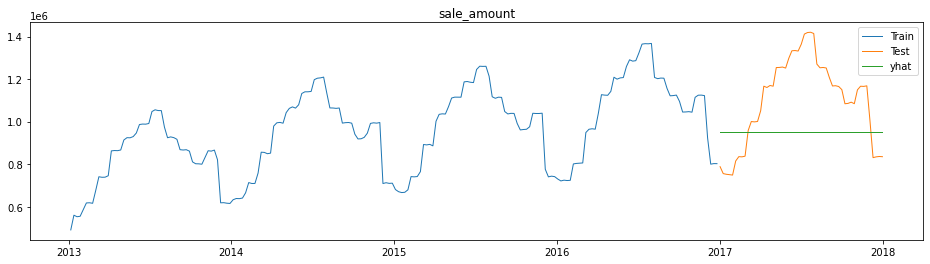

In [17]:
for col in train.columns:
    plot_and_eval(col)

**Append Evaluation Metrics**

In [18]:
# create the evaluation DataFrame
evaluation = pd.DataFrame(columns = ["model_type", "target_var", "rmse"])

# call append_evaluation function
evaluation = append_evaluation(model_type="Simple Average", target_var="quantity")
evaluation = append_evaluation(model_type="Simple Average", target_var="sale_amount")
evaluation

,model_type,target_var,rmse
0,Simple Average,quantity,46568
1,Simple Average,sale_amount,250161


---
**Moving Average**

**Predict**

In [19]:
period = 13 # 13 week rolling average == quarterly

quantity = round(train.quantity.rolling(period).mean().iloc[-1], 2)
sale_amount = round(train.sale_amount.rolling(period).mean().iloc[-1], 2)

yhat = make_predictions()
yhat.head()

,quantity,sale_amount
ds,,
2017-01-01 00:00:00+00:00,187358.92,1006901.42
2017-01-08 00:00:00+00:00,187358.92,1006901.42
2017-01-15 00:00:00+00:00,187358.92,1006901.42
2017-01-22 00:00:00+00:00,187358.92,1006901.42
2017-01-29 00:00:00+00:00,187358.92,1006901.42


**Evaluate**

In [20]:
for col in train.columns:
    print(f"{col} RMSE = {evaluate(col)}")

quantity RMSE = 41323
sale_amount RMSE = 222145


**Plot + Evaluate**

quantity -- RMSE: 41323


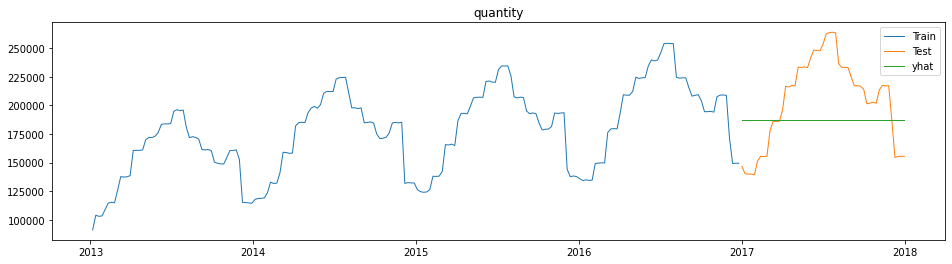

sale_amount -- RMSE: 222145


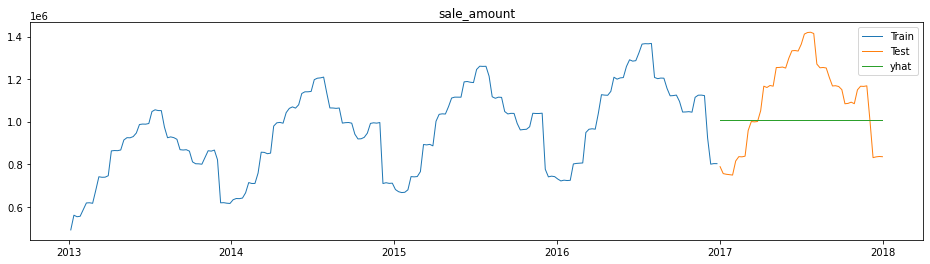

In [21]:
for col in train.columns:
    plot_and_eval(col)

**Append Evaluation Metrics**

In [22]:
evaluation

,model_type,target_var,rmse
0,Simple Average,quantity,46568
1,Simple Average,sale_amount,250161


In [23]:
evaluation = append_evaluation(model_type="13-Week Rolling Avg.", target_var="quantity")
evaluation = append_evaluation(model_type="13-Week Rolling Avg.", target_var="sale_amount")
evaluation

,model_type,target_var,rmse
0,Simple Average,quantity,46568
1,Simple Average,sale_amount,250161
2,13-Week Rolling Avg.,quantity,41323
3,13-Week Rolling Avg.,sale_amount,222145


**Holt's Linear Trend**

**Predict**

In [24]:
yhat.head()

,quantity,sale_amount
ds,,
2017-01-01 00:00:00+00:00,187358.92,1006901.42
2017-01-08 00:00:00+00:00,187358.92,1006901.42
2017-01-15 00:00:00+00:00,187358.92,1006901.42
2017-01-22 00:00:00+00:00,187358.92,1006901.42
2017-01-29 00:00:00+00:00,187358.92,1006901.42


In [25]:
for col in train.columns:
    # create model object
    model = Holt(train[col])

    # fit the object
    model = model.fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)

    # use the object
    yhat_items = model.predict(start=test.index[0], end=test.index[-1])

    yhat[col] = round(yhat_items, 2)

In [26]:
yhat.head()

,quantity,sale_amount
ds,,
2017-01-01 00:00:00+00:00,154946.58,832417.25
2017-01-08 00:00:00+00:00,150657.52,809325.15
2017-01-15 00:00:00+00:00,146368.47,786233.04
2017-01-22 00:00:00+00:00,142079.42,763140.94
2017-01-29 00:00:00+00:00,137790.37,740048.83


**Evaluate**

In [27]:
for col in train.columns:
    print(f"{col} RMSE = {evaluate(col)}")

quantity RMSE = 182185
sale_amount RMSE = 980761


**Plot and Evaluate**

quantity -- RMSE: 182185


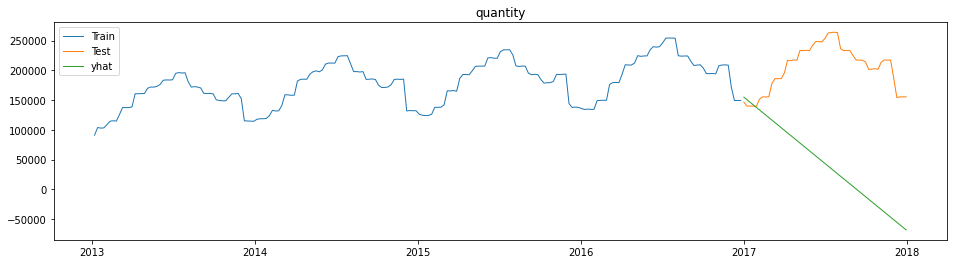

sale_amount -- RMSE: 980761


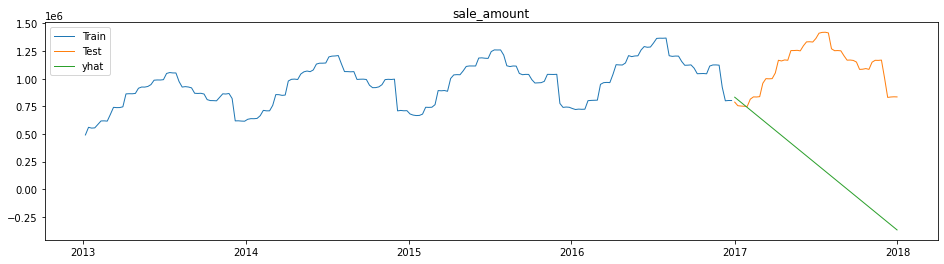

In [28]:
for col in train.columns:
    plot_and_eval(col)

**Append Evaluataion**

In [29]:
evaluation

,model_type,target_var,rmse
0,Simple Average,quantity,46568
1,Simple Average,sale_amount,250161
2,13-Week Rolling Avg.,quantity,41323
3,13-Week Rolling Avg.,sale_amount,222145


In [30]:
evaluation = append_evaluation("Holt's", "quantity")
evaluation = append_evaluation("Holt's", "sale_amount")
evaluation

,model_type,target_var,rmse
0,Simple Average,quantity,46568
1,Simple Average,sale_amount,250161
2,13-Week Rolling Avg.,quantity,41323
3,13-Week Rolling Avg.,sale_amount,222145
4,Holt's,quantity,182185
5,Holt's,sale_amount,980761


**Previous Cycle**

**Predict**

In [31]:
yhat = train["2015-12-27":] + train.diff(52).mean()
yhat.index = pd.date_range("2017-01-01", periods=len(yhat), freq="W")
yhat.head()

,quantity,sale_amount
2017-01-01,153036.717949,823679.915705
2017-01-08,151225.717949,812371.305705
2017-01-15,149622.717949,803461.375705
2017-01-22,150210.717949,807052.055705
2017-01-29,149699.717949,805312.615705


In [32]:
print(yhat.head(1))
print(test.head(1))

                 quantity    sale_amount
2017-01-01  153036.717949  823679.915705
                           quantity  sale_amount
ds                                              
2017-01-01 00:00:00+00:00  146640.0    788100.24


In [33]:
print(len(yhat))
print(len(test))

53
53


**Plot + Evaluate**

**Append Evaluation**

quantity -- RMSE: 11348


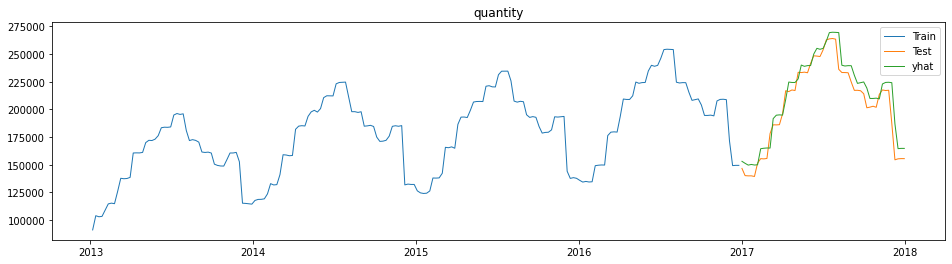

sale_amount -- RMSE: 61014


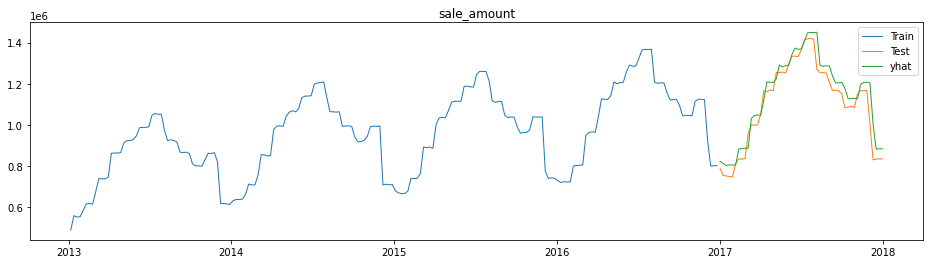

In [34]:
for col in train.columns:
    plot_and_eval(col)
    evaluation = append_evaluation("Previous 52 Weeks", col)

In [35]:
evaluation

,model_type,target_var,rmse
0,Simple Average,quantity,46568
1,Simple Average,sale_amount,250161
2,13-Week Rolling Avg.,quantity,41323
3,13-Week Rolling Avg.,sale_amount,222145
4,Holt's,quantity,182185
5,Holt's,sale_amount,980761
6,Previous 52 Weeks,quantity,11348
7,Previous 52 Weeks,sale_amount,61014


## Conclusion

Which model performed best?

In [36]:
# get the min rmse for each variable

min_rmse_quantity = evaluation.groupby('target_var')['rmse'].min()[0]
min_rmse_sale_amount = evaluation.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
evaluation[((evaluation.rmse == min_rmse_quantity) | 
         (evaluation.rmse == min_rmse_sale_amount)
        )]

,model_type,target_var,rmse
6,Previous 52 Weeks,quantity,11348
7,Previous 52 Weeks,sale_amount,61014


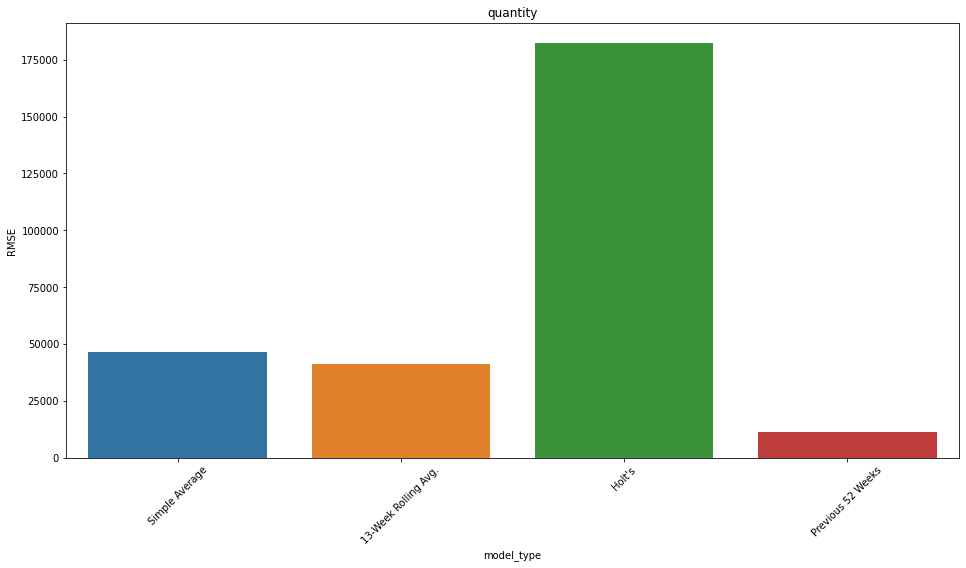

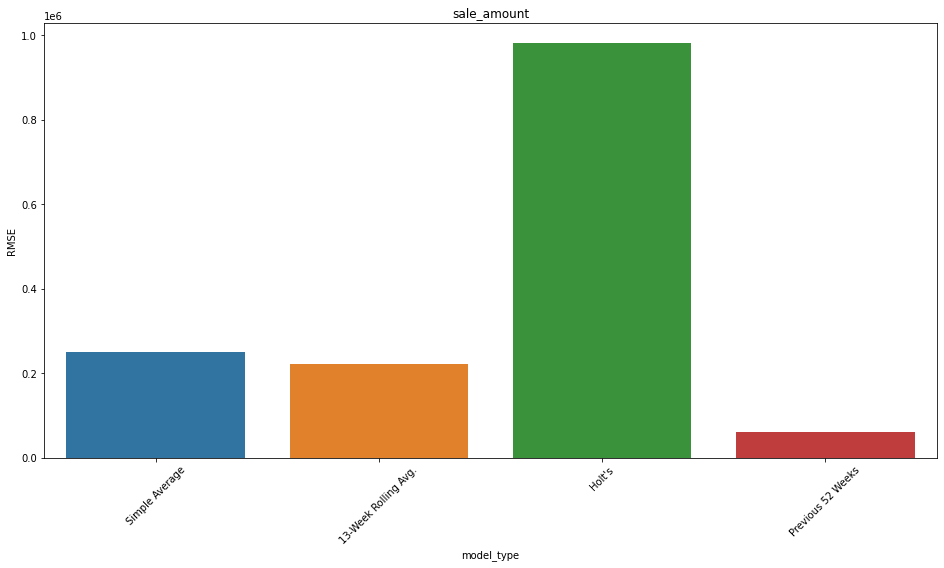

In [37]:
for col in train.columns:
    x = evaluation[evaluation.target_var == col]['model_type']
    y = evaluation[evaluation.target_var == col]['rmse']
    plt.figure(figsize=(16, 8))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()